Advanced Lane Finding Project

In [1]:
import glob
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from moviepy.video.io.VideoFileClip import VideoFileClip

mtx = 0
dist = 0
nx = 9
ny = 6
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
left_detected = False
right_detetcted = False
left_fit_prev = None
right_fit_prev = None

In [2]:
def camera_calibrate():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for i, name in enumerate(glob.glob("camera_cal/calibration*.jpg")):
        img = plt.imread(name)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True :
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx,dist

mtx , dist = camera_calibrate()

In [3]:
def undistort(img,mtx,dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

Text(0.5,1,'Undistorted Image')

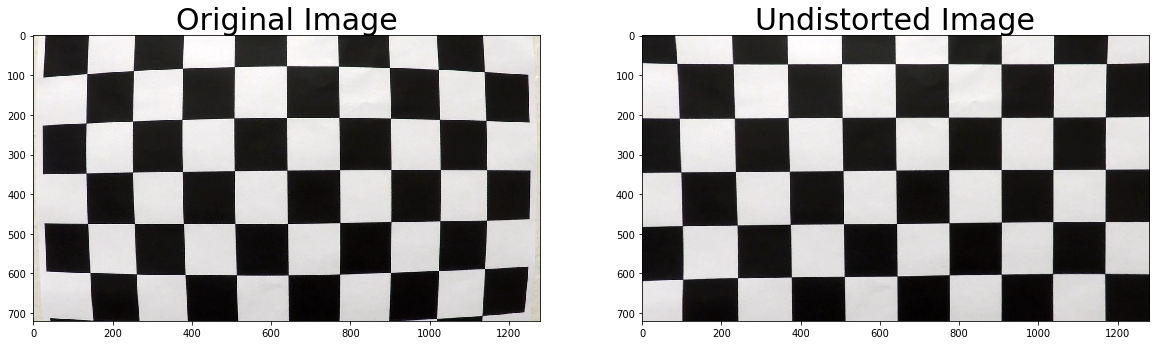

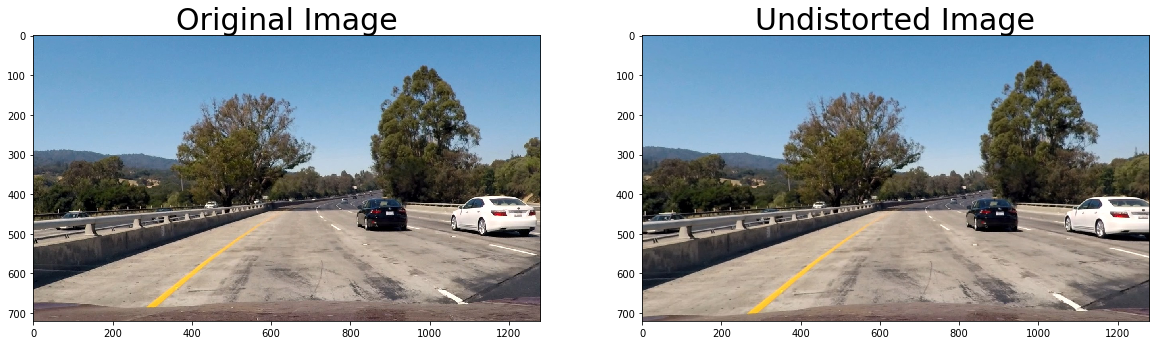

In [4]:
cal_image = plt.imread('camera_cal/calibration1.jpg')
undistorted_cal_image = undistort(cal_image,mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_cal_image)
ax2.set_title('Undistorted Image', fontsize=30)

test_image = plt.imread('test_images/test1.jpg')
undistorted_test_image = undistort(test_image,mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_test_image)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
def abs_sobel_thresh(img, orient='x', k_size=3,thresh_min=0, thresh_max=255):
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0,k_size))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1,k_size))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

Text(0.5,1,'Combined')

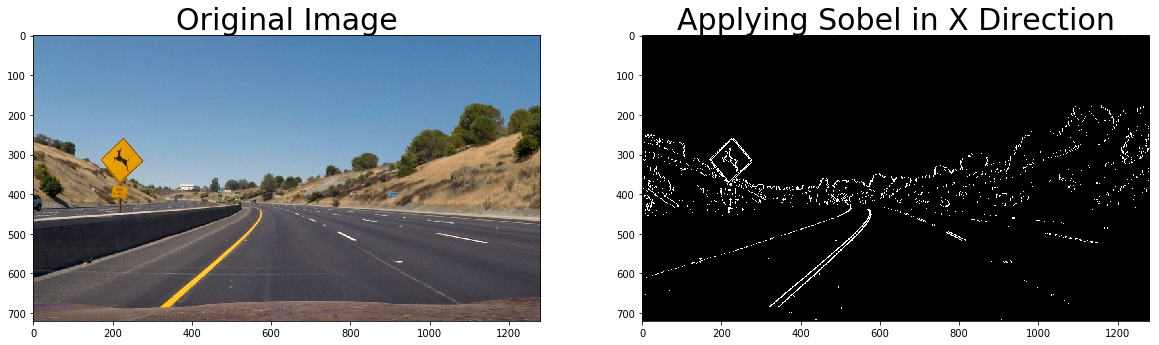

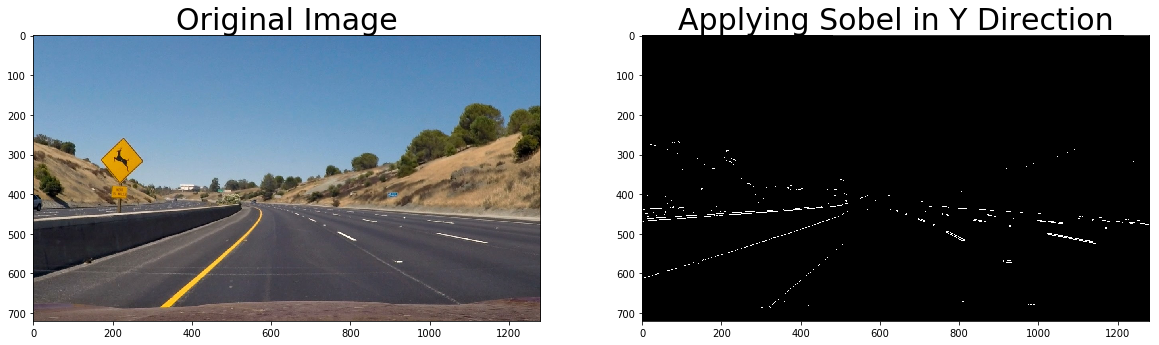

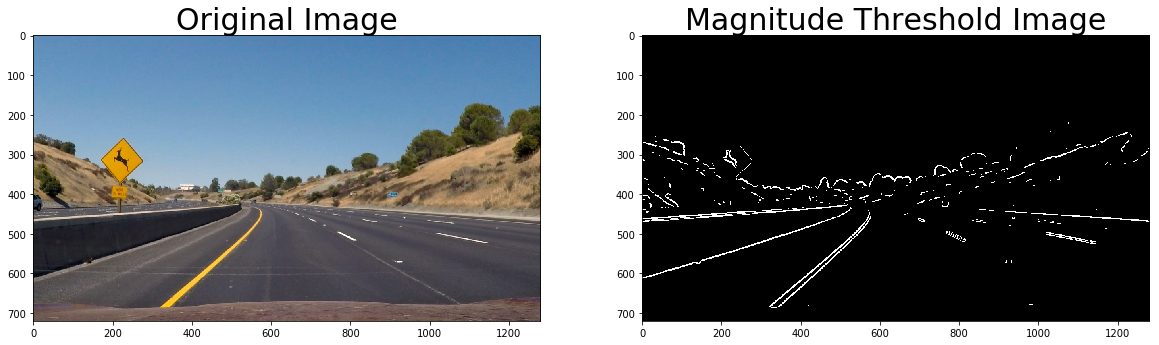

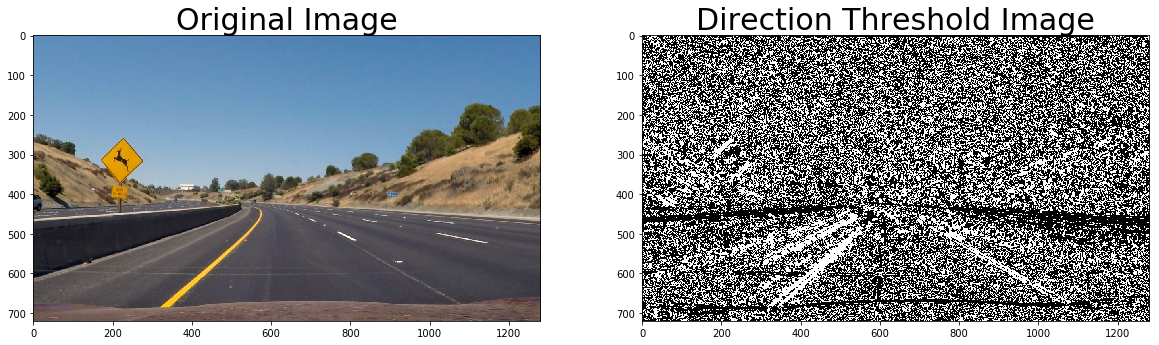

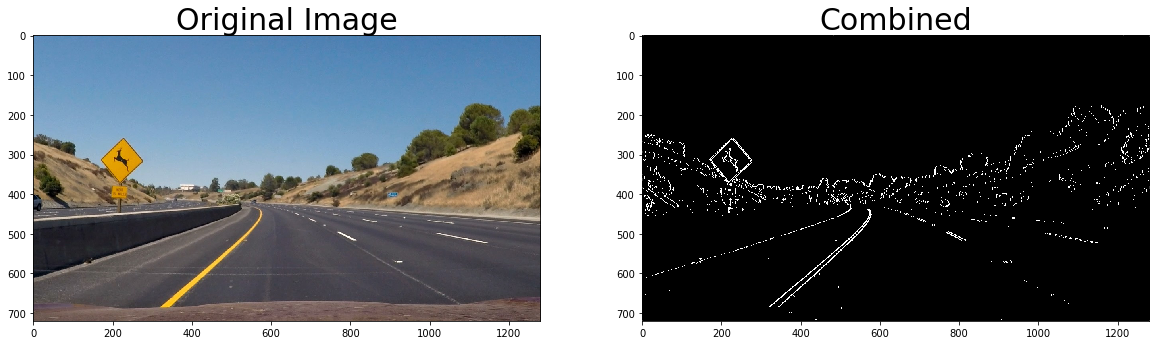

In [8]:
sobelx_test_image = cv2.imread('test_images/test2.jpg')
sobelx_output_image = abs_sobel_thresh(cv2.cvtColor(sobelx_test_image, cv2.COLOR_BGR2GRAY), orient='x',k_size = 15, thresh_min=40, thresh_max=255)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(sobelx_test_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(sobelx_output_image, cmap = 'gray')
ax2.set_title('Applying Sobel in X Direction', fontsize=30)


sobely_test_image = cv2.imread('test_images/test2.jpg')
sobely_output_image = abs_sobel_thresh(cv2.cvtColor(sobely_test_image, cv2.COLOR_BGR2GRAY), orient='y',k_size = 15, thresh_min=100, thresh_max=255)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(sobely_test_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(sobely_output_image, cmap = 'gray')
ax2.set_title('Applying Sobel in Y Direction', fontsize=30)

magThreshold_image = cv2.imread('test_images/test2.jpg')
magThreshold_output_image = mag_thresh(cv2.cvtColor(magThreshold_image, cv2.COLOR_BGR2GRAY), sobel_kernel=15, mag_thresh=(100, 200))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(magThreshold_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(magThreshold_output_image,cmap = 'gray')
ax2.set_title('Magnitude Threshold Image', fontsize=30)

dirThreshold_image = cv2.imread('test_images/test2.jpg')
dirThreshold_test_image = dir_threshold(cv2.cvtColor(dirThreshold_image, cv2.COLOR_BGR2GRAY), sobel_kernel=15, thresh=(0.7,1.3))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(dirThreshold_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dirThreshold_test_image,cmap = 'gray')
ax2.set_title('Direction Threshold Image', fontsize=30)

combined_output_image = np.zeros_like(dirThreshold_test_image)

combined_test_image = cv2.imread('test_images/test2.jpg')
combined_output_image[((sobelx_output_image == 1))  | ((magThreshold_output_image == 1) & (dirThreshold_test_image == 1))] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(sobelx_test_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(sobelx_output_image, cmap = 'gray')
ax2.set_title('Combined', fontsize=30)


In [9]:
def color_gradient_transform(img, s_thresh=(170, 255), sx_thresh=(35, 100),k_size = 15):
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    h_thresh=(20,25)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    h_channel = hls[:,:,0]
    

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 30
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary,color_binary

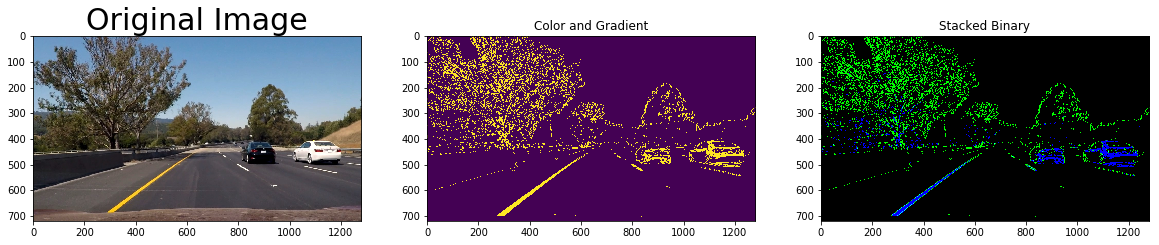

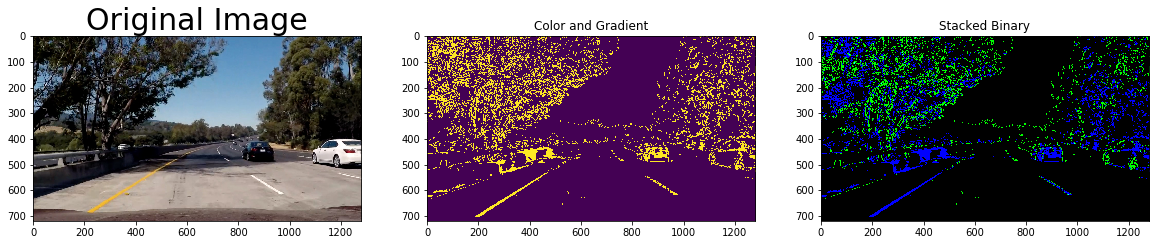

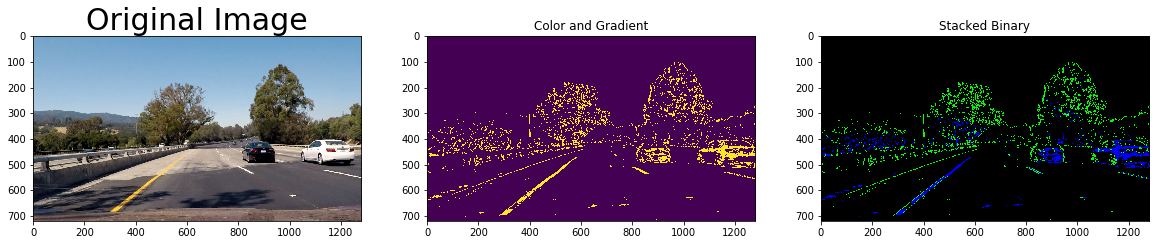

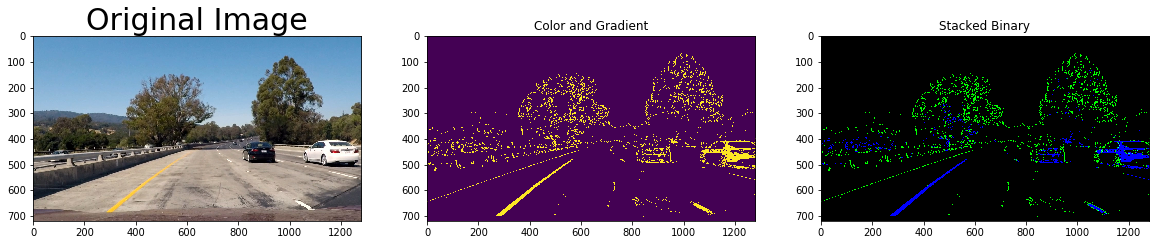

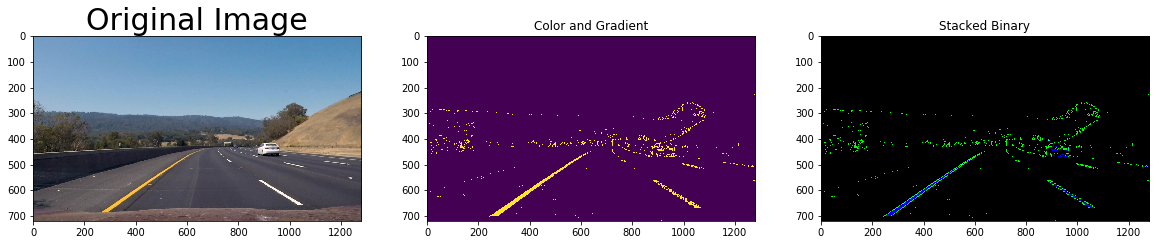

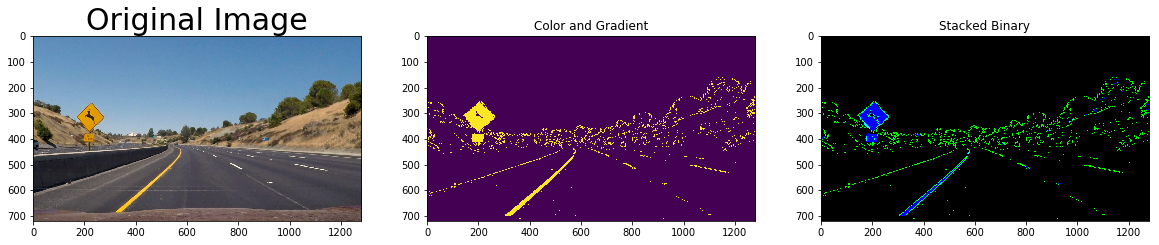

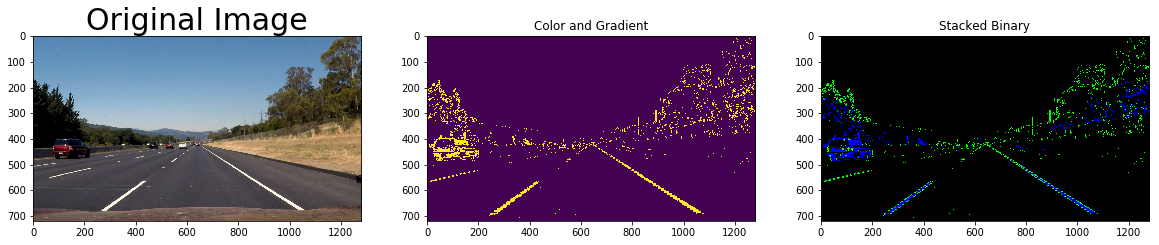

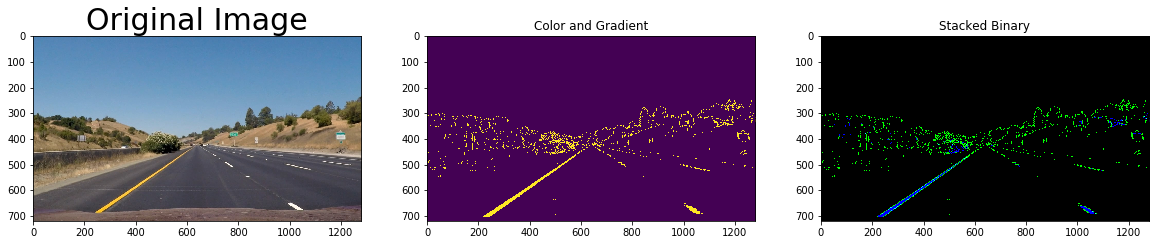

In [10]:
for image in glob.glob("test_images/*.jpg"):
    test_image = plt.imread(image)
    undistorted_test_image = undistort(test_image,mtx,dist)
    color_gradient_image,stacked_binary = color_gradient_transform(undistorted_test_image,s_thresh=(170, 255), sx_thresh=(35,100),k_size=15)
    f, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(20,20))
    ax1.imshow(test_image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(color_gradient_image)
    ax2.set_title('Color and Gradient')
    ax3.imshow(stacked_binary)
    ax3.set_title('Stacked Binary')



In [11]:
def corners_unwarp(img):
    
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([[578,462],[701,462],[1040,680],[260,680]])
    dst = np.float32([[260,0],[1040,0],[1040,720],[260,720]])
    
    srcp = np.float32([[578,462],[701,462],[1040,680],[260,680]])
    dstp = np.float32([[260,0],[1040,0],[1040,720],[260,720]])
    
    # Given src and dst points, calculate the perspective transform matrix 
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size,)
    warpedinv = cv2.warpPerspective(img, Minv, img_size)
    #cv2.polylines(img, [srcp], 1, (255, 0, 0), 5)
    #cv2.polylines(img, [dstp], 1, (0, 255, 0), 5)
    # Return the resulting image and matrix
    return M,Minv,warped,warpedinv,img

Text(0.5,1,'Poly Image')

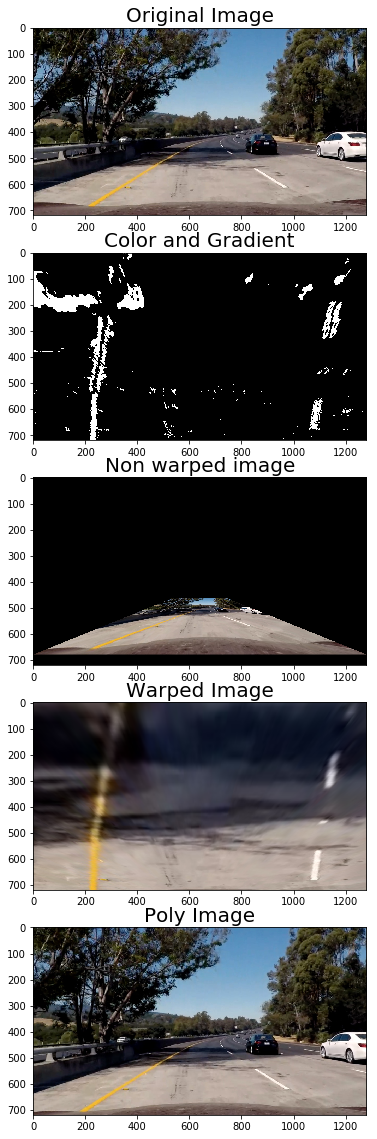

In [12]:

test_image = plt.imread('test_images/test5.jpg')
undistorted_test_image = undistort(test_image,mtx,dist)
Mt,Mtinv,warpedImage,warpedinvImage,poly_img = corners_unwarp(undistorted_test_image)
color_gradient_image,stacked_binary = color_gradient_transform(warpedImage,s_thresh=(170, 255), sx_thresh=(35,100),k_size=15)
f, (ax1, ax2 , ax3, ax4,ax5) = plt.subplots(5, 1, False,False,figsize=(20,20))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(color_gradient_image, cmap='gray')
ax2.set_title('Color and Gradient',fontsize=20)
ax3.imshow(warpedinvImage)
ax3.set_title('Non warped image',fontsize=20)
ax4.imshow(warpedImage)
ax4.set_title("Warped Image",fontsize=20)
ax5.imshow(poly_img)
ax5.set_title("Poly Image",fontsize=20)

In [13]:
def find_lane_pixels(binary_warped,video=0):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
       
    
    if not video:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    return left_fit,right_fit,ploty,out_img
    

In [14]:
def search_around_poly(binary_warped,left_fit,right_fit,video=0):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    if lefty.shape[0] < 10 or righty.shape[0] < 10:
        return None, None, None, None, None, None, None
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    if not video:
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
    else:
        result = None


    return left_fit,right_fit,ploty,result

In [15]:
def draw_lanes(image,left_fit,right_fit,Minv):
    
    warp_zero = np.zeros_like(image).astype(np.uint8)
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 0.7, newwarp, 0.3, 0)
    return result

In [16]:
def measure_curvature_real():
    
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    # Define conversions in x and y from pixels space to meters
    
    
    # Define y-value where we want radius of curvature
    
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [17]:

def pipleline(test_image):
    global left_detected
    global left_fit_prev
    global right_fit_prev
    undistorted_test_image = undistort(test_image,mtx,dist) 
    color_gradient_image,stacked = color_gradient_transform(undistorted_test_image,s_thresh=(170, 255), sx_thresh=(35,100),k_size=15)
    Mt,Mtinv,warpedImage,warpedinvImage,poly_image = corners_unwarp(color_gradient_image)
    if left_detected is False:
        left_fit_prev,right_fit_prev,ploty_prev,out_img_prev = find_lane_pixels(warpedImage,video = 1)
        lanes_image = draw_lanes(undistorted_test_image,left_fit_prev,right_fit_prev,Mtinv)   
        left_detected = True
    else: 
        left_fit,right_fit,ploty,result=search_around_poly(warpedImage,left_fit_prev,right_fit_prev,video =1)
        lanes_image = draw_lanes(undistorted_test_image,left_fit,right_fit,Mtinv)
    return lanes_image

In [18]:

project_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(pipleline) 
project_clip.write_videofile(project_output, audio=False)


[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

UnboundLocalError: local variable 'left_fit_prev' referenced before assignment